In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import wandb


# Data Pre-Processing

In [2]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)
labels = df.columns.tolist()
print(df)


        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...  ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786    1  273   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875    1  273   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675    1  273   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889    1  273   
505  0.04741   0.0  11.93   0.0  0.573  6.030   NaN  2.5050    1  273   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  3

In [3]:
# describing the dataset
stats = df.describe().transpose()
stats['attribute'] = stats.index
stats = stats[['attribute', 'mean', 'std', 'min', 'max']]
table = tabulate(stats, headers='keys', tablefmt='pretty', showindex=False)
print('Description of Dataset using mean, standard deviation, min, and max of all attributes')
print(table)

Description of Dataset using mean, standard deviation, min, and max of all attributes
+-----------+---------------------+---------------------+---------+---------+
| attribute |        mean         |         std         |   min   |   max   |
+-----------+---------------------+---------------------+---------+---------+
|   CRIM    | 3.6118739711934156  |  8.720191850151599  | 0.00632 | 88.9762 |
|    ZN     |  11.2119341563786   | 23.388876146265577  |   0.0   |  100.0  |
|   INDUS   | 11.083991769547332  |  6.835896498641465  |  0.46   |  27.74  |
|   CHAS    | 0.06995884773662552 | 0.25534048090656764 |   0.0   |   1.0   |
|    NOX    | 0.5546950592885372  | 0.11587767566755611 |  0.385  |  0.871  |
|    RM     |  6.284634387351787  | 0.7026171434153237  |  3.561  |  8.78   |
|    AGE    |  68.51851851851852  | 27.999513005092375  |   2.9   |  100.0  |
|    DIS    |  3.795042687747034  | 2.1057101266276104  | 1.1296  | 12.1265 |
|    RAD    |  9.549407114624506  |  8.707259384239377  

## Standardizing the dataset (min-max)

In [16]:
features = df.iloc[:, :-1]  
target = df.iloc[:, -1]

# minmax sccaler
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

df = pd.DataFrame(normalized_features, columns=features.columns)
df['MEDV'] = target.values

print(df)


         CRIM    ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0    0.000000  0.18  0.067815   0.0  0.314815  0.577505  0.641607  0.269203   
1    0.000236  0.00  0.242302   0.0  0.172840  0.547998  0.782698  0.348962   
2    0.000236  0.00  0.242302   0.0  0.172840  0.694386  0.599382  0.348962   
3    0.000293  0.00  0.063050   0.0  0.150206  0.658555  0.441813  0.448545   
4    0.000705  0.00  0.063050   0.0  0.150206  0.687105  0.528321  0.448545   
..        ...   ...       ...   ...       ...       ...       ...       ...   
501  0.000633  0.00  0.420455   0.0  0.386831  0.580954  0.681771  0.122671   
502  0.000438  0.00  0.420455   0.0  0.386831  0.490324  0.760041  0.105293   
503  0.000612  0.00  0.420455   0.0  0.386831  0.654340  0.907312  0.094381   
504  0.001161  0.00  0.420455   0.0  0.386831  0.619467  0.889804  0.114514   
505  0.000462  0.00  0.420455   0.0  0.386831  0.473079       NaN  0.125072   

          RAD       TAX   PTRATIO         B     LST

## Distribution of values in the dataset

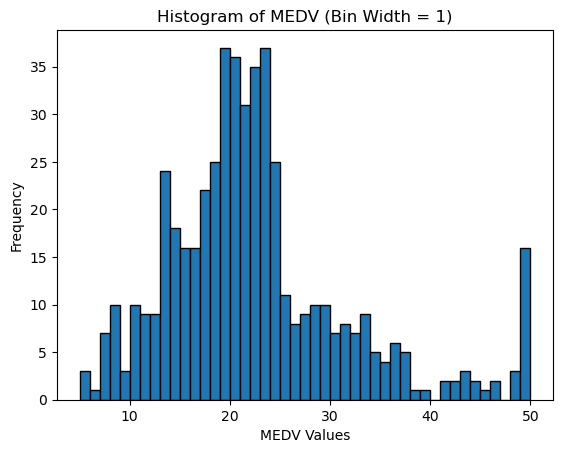

In [17]:
bin_width = 1

bins = np.arange(min(df['MEDV']), max(df['MEDV']) + bin_width, bin_width)

plt.hist(df['MEDV'], bins=bins, edgecolor='black')

plt.xlabel('MEDV Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of MEDV (Bin Width = {bin_width})')

plt.show()


In [18]:
X = df
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Finding out missing values, negative values, outliers

In [19]:
missing_values = df.isnull().sum()
negative_values = (df < 0).sum()
z_scores = np.abs(zscore(df))
outliers_count = np.sum(z_scores > 3, axis=0)

attributes = df.columns
data = []
for attribute, missing, negative, outliers in zip(attributes, missing_values, negative_values, outliers_count):
    data.append([attribute, missing, negative, outliers])

# printing in the form of a table
table_df = pd.DataFrame(data, columns=['Attribute', 'Missing Values', 'Negative Values', 'Outliers'])
print(tabulate(table_df, headers='keys', tablefmt='pretty', showindex=False))


+-----------+----------------+-----------------+----------+
| Attribute | Missing Values | Negative Values | Outliers |
+-----------+----------------+-----------------+----------+
|   CRIM    |       20       |        0        |    0     |
|    ZN     |       20       |        0        |    0     |
|   INDUS   |       20       |        0        |    0     |
|   CHAS    |       20       |        0        |    0     |
|    NOX    |       0        |        0        |    0     |
|    RM     |       0        |        0        |    8     |
|    AGE    |       20       |        0        |    0     |
|    DIS    |       0        |        0        |    5     |
|    RAD    |       0        |        0        |    0     |
|    TAX    |       0        |        0        |    0     |
|  PTRATIO  |       0        |        0        |    0     |
|     B     |       0        |        0        |    25    |
|   LSTAT   |       20       |        0        |    0     |
|   MEDV    |       0        |        0 

## Replacing missing (nan) values by k

In [20]:
k = 0
df = df.fillna(k)

In [21]:
missing_values = df.isnull().sum()
negative_values = (df < 0).sum()
z_scores = np.abs(zscore(df))
outliers_count = np.sum(z_scores > 3, axis=0)

attributes = df.columns
data = []
for attribute, missing, negative, outliers in zip(attributes, missing_values, negative_values, outliers_count):
    data.append([attribute, missing, negative, outliers])

# printing in the form of a table
table_df = pd.DataFrame(data, columns=['Attribute', 'Missing Values', 'Negative Values', 'Outliers'])
print(tabulate(table_df, headers='keys', tablefmt='pretty', showindex=False))


+-----------+----------------+-----------------+----------+
| Attribute | Missing Values | Negative Values | Outliers |
+-----------+----------------+-----------------+----------+
|   CRIM    |       0        |        0        |    8     |
|    ZN     |       0        |        0        |    28    |
|   INDUS   |       0        |        0        |    0     |
|   CHAS    |       0        |        0        |    34    |
|    NOX    |       0        |        0        |    0     |
|    RM     |       0        |        0        |    8     |
|    AGE    |       0        |        0        |    0     |
|    DIS    |       0        |        0        |    5     |
|    RAD    |       0        |        0        |    0     |
|    TAX    |       0        |        0        |    0     |
|  PTRATIO  |       0        |        0        |    0     |
|     B     |       0        |        0        |    25    |
|   LSTAT   |       0        |        0        |    5     |
|   MEDV    |       0        |        0 

---
# Multi-Layer Perceptron for Regression

In [24]:
class MLP:
    
    def __init__(self,layer_sizes, batch_size, num_epoches, learning_rate, activation_function, optimization):
        self.layer_sizes = layer_sizes # number of neurons in each layer
        self.num_layers = len(self.layer_sizes) # total number of layers
        self.batch_size = batch_size # only for mini-batch gradient descent
        self.epoches = num_epoches
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimization = optimization
        
        # initializing weights (needed once only)
        self.initialize_weights()
        
        # validation loss and acc
        self.validation_loss = []
        self.validation_accuracy = []
        
        # training loss and acc
        self.L = []
        self.A = []
        
        print('Initialized values successfully!')
    
    def printParameters(self):
        print('-----------------------------------------------')
        print('Number of Layers          : ',self.num_layers)
        print('Layer sizes               : ',self.layer_sizes)
        print('Batch size(if mini-batch) : ',self.batch_size)
        print('Activation Function       : ',self.activation_function)
        print('Optimization Method       : ',self.optimization)
        print('Learning Rate             : ',self.learning_rate)
        print('Num Epoches               : ',self.epoches)
        print('-----------------------------------------------')

    
    # loads the dataframe into the class
    def loadData(self,df):
        self.num_features = df.shape[1]-1
        self.num_classes = df.iloc[:, -1].nunique()
        self.df = df
        print('Loaded Dataframe!')

    # splits the dataframe loaded into train, validation and test sets
    def splitData(self,train_fraction,normalize):
        X = df.iloc[:, :-1].values
        
        # Replace NaN values with the constant k
        nan_mask = np.isnan(X)
        k = 0
        X[nan_mask] = k

        if normalize:
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            X = (X - mean) / std
        y = df.iloc[:, -1].values
        

        self.X_train, X_temp, self.y_train, y_temp = train_test_split(X, y, test_size=1-train_fraction, random_state=42)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        print('Splitted data into train, test and val sets!')
        
        
    # returns the one-hot encoded version of a given vector
    def oneHotEncoding(self, y):
        return y
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def categorical(self,x):  
        return x
    
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.argmax(x,axis=1)
        return categorical

# defining activation functions and their derivatives
#--------------------------------------------------------------------------------------------

    # SIGMOID
    def sigmoid(self,z):
        val = 1/(1+np.exp(-z))
        return val
    
    def sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    # ReLU 
    def ReLU(self, z):
        ret = np.maximum(z, 0)
        if ret.shape!=z.shape:
            print('whaat??')
        return ret
    def ReLU_prime(self, h):
        return np.where(h >= 0, 1, 0)
    
    # tanh
    def hyperbolic_tan(self, z):
        val = (2/(np.exp(-2*z)+1)) -1
        val = expit(2 * z) - 1
        return val
    
    def hyperbolic_tan_prime(self, h):
        return 1-h**2
    
    # linear (can change slope and intercept)
    def linear(self, z):
        return z
    def linear_prime(self,h):
        return 1
    
#-----------------activation function for last layer (output) -------------------------------



#---------------------------------------------------------------------------------------------

    def activation(self,z):
        if self.activation_function=='sigmoid':
            return self.sigmoid(z)
        elif self.activation_function=='ReLU':
            return self.ReLU(z)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan(z)
        elif self.activation_function=='linear':
            return self.linear(z)
        else:
            raise ValueError("Invalid Activation function")

    def activation_prime(self,h):
        if self.activation_function=='sigmoid':
            return self.sigmoid_prime(h)
        elif self.activation_function=='ReLU':
            return self.ReLU_prime(h)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan_prime(h)
        elif self.activation_function=='linear':
            return self.linear_prime(h)
        else:
            raise ValueError("Invalid Activation function")

#---------------------------------------------------------------------------------------------


    def loss(self, y_hat, y):
        y = y.reshape(-1,1)
        return np.sum((y_hat-y)**2)
    
    def accuracy(self, y_hat, y):  
        nan_mask = np.isnan(y)
        k = 0
        y[nan_mask] = k
        nan_mask = np.isnan(y_hat)
        k = 0
        y_hat[nan_mask] = k
        

        mse = mean_squared_error(y_hat, y)
        return mse


    def initialize_weights(self):
        self.weights = []
        #weights[i] is a m,n matrix giving weight connecting the i and i+1th layer
        
        mean_weight = 0  # Mean of the normal distribution
        std_dev_weight = 1  # Standard deviation of the normal distribution
        min_weight = -1
        max_weight = 1
        for i in range(self.num_layers-1):
            sz = [self.layer_sizes[i],self.layer_sizes[i+1]]
            wt = np.random.normal(mean_weight, std_dev_weight, size=sz)

            self.weights.append(wt)
        
    def initialize_layers(self,batch_size):
        self.hidden_layers = [np.ones((batch_size,layer_size)) for layer_size in layer_sizes]
        
    # takes in a batch of data (num_samples x num_features) and applies feed-forward on it
    def feedforward(self, batch):
        current_layer = batch
        self.hidden_layers[0] = batch

        for i,weights in enumerate(self.weights):
            current_layer = self.activation(np.dot(current_layer,weights))

            self.hidden_layers[i+1] = current_layer
            
        # last layer is the output layer
        self.output_layer = (self.hidden_layers[-1])
        
    # goes from the last layer to the 1st layer updating weights according to GD
    def backpropogation(self, y):
        # evaluating the last layer error : del
        y = y.reshape(-1, 1)
        del_t = -(y - self.output_layer)
        for i in range(1,self.num_layers):
            # calculating the gradient of weights and applying gradient-descent
            dJ_dW = np.dot(self.hidden_layers[-i-1].T,del_t)/self.batch_size
            self.weights[-i] = self.weights[-i] - self.learning_rate * dJ_dW
            # updating the error for the next layer 
            del_t = np.dot(del_t,self.weights[-i].T)*self.activation_prime(self.hidden_layers[-i-1])
                    
    def validate(self):
        n,m = self.X_val.shape[0:2]
        self.initialize_layers(batch_size=n)
        self.feedforward(self.X_val)
        val_loss = self.loss(self.output_layer,self.y_val)
        val_acc = self.accuracy(self.categorical(self.output_layer),self.y_val)
        self.validation_loss.append(val_loss)
        self.validation_accuracy.append(val_acc)
        
    def mini_batch_GD(self):
            self.initialize_layers(self.batch_size)
            loss_sum = 0
            accuracy_sum = 0
            
            # calculating the total number of batches (acc to batch sizee)
            num_batches = self.X_train.shape[0]/self.batch_size
            ind = np.random.permutation(self.X_train.shape[0])
            
            
            # splitting the X_train, Y_train into batches
            X_batches = np.array_split(self.X_train[ind], num_batches)
            Y_batches = np.array_split(self.y_train[ind], num_batches)
            data_batches = zip(X_batches,Y_batches)
            
            # performing feed-forward -> saving training loss and accuracy -> back-propogation
            for data_x, data_y in data_batches:
                self.feedforward(data_x)

                loss_sum = loss_sum + self.loss(self.output_layer,data_y)
                accuracy_sum = accuracy_sum + self.accuracy(self.categorical(self.output_layer),data_y)
                self.backpropogation(data_y)
            
            loss_train = loss_sum/num_batches
            acc_train = accuracy_sum/num_batches
            
            return loss_train, acc_train
        
    def batch_GD(self):
        self.batch_size = self.X_train.shape[0]
        loss_train, acc_train = self.mini_batch_GD()
        return loss_train, acc_train
        
    def SGD(self):
        self.batch_size = 1
        loss_train, acc_train = self.mini_batch_GD()
        return loss_train, acc_train
    
    # general method for optimization (batch/mini-batch/SGD)
    def optimize(self):
        if self.optimization=='mini-batch':
            return self.mini_batch_GD()
        elif self.optimization=='batch':
            return self.batch_GD()
        elif self.optimization=='SGD':
            return self.SGD()
    
    def fit(self):
        for epoch in range(self.epoches):
            # Gradient Descent
            loss_train, acc_train = self.optimize()
            
            # calculating accuracy and loss for current epoch and saving them
            self.L.append(loss_train)
            self.A.append(acc_train)
            
            # testing the current model on validation set and saving the loss and accuracy
            self.validate()
#             print('Epoch : ',epoch+1,' loss : ',loss_train.round(3),' acc : ',acc_train.round(3))
            wandb.log({"loss (MSE) ": loss_train.round(3)})

            
            
    def predict(self):
        self.y_test = self.y_test.reshape(-1,1)
        self.feedforward(self.X_test)
        
        plt.plot(self.output_layer,label='Predicted')
        plt.plot(self.y_test,label='Ground Truth')
        plt.title('Predicted Values vs Ground Truth')
        plt.grid()
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
        
        y_test = self.y_test
        output_layer = self.output_layer
        
        print('--------------------------------------------------------------------------------')
        
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, output_layer)
        print(f'Mean Squared Error (MSE)                 : {mse:.2f}')

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        print(f'Root Mean Squared Error (RMSE)           : {rmse:.2f}')

        # Calculate R-squared (Coefficient of Determination)
        r_squared = r2_score(y_test, output_layer)
        print(f'R-squared (Coefficient of Determination) : {r_squared:.2f}')
        
        print('--------------------------------------------------------------------------------')


### Loading the dataset from csv file

In [11]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

number of samples  :  506
number of features :  13


### Creating the MLP Regression Model and setting up hyperparameters

In [885]:

# parameters for the model
# the 1st and last element of layer_sizes correspond to number of features and number of outputs
layer_sizes = [13,5,5,1]
batch_size = 50
num_epoches = 500
learning_rate = 0.0001
activation_function = 'ReLU'
optimization = 'mini-batch'

# creating the model object
mlp = MLP(layer_sizes=layer_sizes,
          batch_size=batch_size,
          num_epoches=num_epoches,
          learning_rate=learning_rate,
          activation_function=activation_function,
          optimization=optimization,
         )

mlp.loadData(df)
mlp.splitData(0.8,True)
mlp.printParameters()

Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers          :  4
Layer sizes               :  [13, 5, 5, 1]
Batch size(if mini-batch) :  50
Activation Function       :  ReLU
Optimization Method       :  mini-batch
Learning Rate             :  0.0001
Num Epoches               :  500
-----------------------------------------------


In [886]:
mlp.fit()

Epoch :  1  loss :  22437.099  acc :  444.457
Epoch :  2  loss :  21653.882  acc :  428.987
Epoch :  3  loss :  20971.017  acc :  415.167
Epoch :  4  loss :  20363.495  acc :  403.433
Epoch :  5  loss :  19819.989  acc :  392.389
Epoch :  6  loss :  19328.952  acc :  382.485
Epoch :  7  loss :  18878.785  acc :  373.686
Epoch :  8  loss :  18460.082  acc :  365.745
Epoch :  9  loss :  18068.832  acc :  357.758
Epoch :  10  loss :  17689.633  acc :  350.401
Epoch :  11  loss :  17320.985  acc :  342.959
Epoch :  12  loss :  16961.406  acc :  335.721
Epoch :  13  loss :  16604.897  acc :  328.752
Epoch :  14  loss :  16248.958  acc :  321.769
Epoch :  15  loss :  15899.458  acc :  314.704
Epoch :  16  loss :  15545.908  acc :  308.0
Epoch :  17  loss :  15191.705  acc :  300.679
Epoch :  18  loss :  14843.89  acc :  293.828
Epoch :  19  loss :  14492.834  acc :  287.016
Epoch :  20  loss :  14153.406  acc :  280.406
Epoch :  21  loss :  13815.554  acc :  273.413
Epoch :  22  loss :  1347

Epoch :  183  loss :  3420.986  acc :  67.686
Epoch :  184  loss :  3416.405  acc :  67.561
Epoch :  185  loss :  3402.835  acc :  67.36
Epoch :  186  loss :  3398.976  acc :  67.377
Epoch :  187  loss :  3392.266  acc :  67.264
Epoch :  188  loss :  3386.246  acc :  67.234
Epoch :  189  loss :  3385.528  acc :  66.891
Epoch :  190  loss :  3374.893  acc :  66.825
Epoch :  191  loss :  3369.115  acc :  66.816
Epoch :  192  loss :  3365.759  acc :  66.672
Epoch :  193  loss :  3361.62  acc :  66.539
Epoch :  194  loss :  3352.228  acc :  66.416
Epoch :  195  loss :  3350.213  acc :  66.359
Epoch :  196  loss :  3343.895  acc :  66.279
Epoch :  197  loss :  3336.421  acc :  66.086
Epoch :  198  loss :  3331.519  acc :  66.034
Epoch :  199  loss :  3327.864  acc :  66.036
Epoch :  200  loss :  3324.173  acc :  65.758
Epoch :  201  loss :  3321.009  acc :  65.642
Epoch :  202  loss :  3307.426  acc :  65.495
Epoch :  203  loss :  3303.596  acc :  65.523
Epoch :  204  loss :  3298.157  acc 

Epoch :  362  loss :  2747.763  acc :  54.394
Epoch :  363  loss :  2743.381  acc :  54.46
Epoch :  364  loss :  2742.65  acc :  54.303
Epoch :  365  loss :  2743.56  acc :  54.31
Epoch :  366  loss :  2738.056  acc :  54.19
Epoch :  367  loss :  2733.042  acc :  54.146
Epoch :  368  loss :  2731.109  acc :  54.135
Epoch :  369  loss :  2728.246  acc :  54.064
Epoch :  370  loss :  2725.618  acc :  54.027
Epoch :  371  loss :  2723.009  acc :  54.09
Epoch :  372  loss :  2724.051  acc :  53.748
Epoch :  373  loss :  2719.587  acc :  53.871
Epoch :  374  loss :  2718.653  acc :  53.695
Epoch :  375  loss :  2714.022  acc :  53.66
Epoch :  376  loss :  2711.313  acc :  53.671
Epoch :  377  loss :  2709.816  acc :  53.688
Epoch :  378  loss :  2705.166  acc :  53.499
Epoch :  379  loss :  2703.483  acc :  53.652
Epoch :  380  loss :  2702.044  acc :  53.52
Epoch :  381  loss :  2698.713  acc :  53.466
Epoch :  382  loss :  2695.668  acc :  53.381
Epoch :  383  loss :  2694.183  acc :  53.

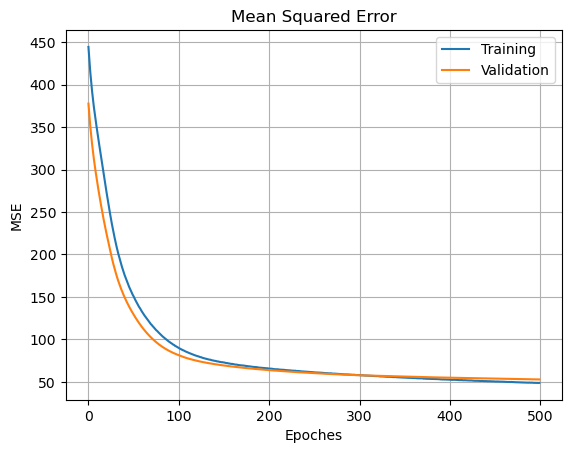

In [887]:
# plt.figure(figsize=(12,3))

# adding base condition to get initial accuracy of 0

plt.plot(mlp.A,label='Training')
plt.plot(mlp.validation_accuracy,label='Validation')
plt.title('Mean Squared Error')
plt.grid()
plt.xlabel('Epoches')
plt.ylabel('MSE')
plt.legend()

plt.show()



## Testing the model on Test-data and reporting Loss Scores

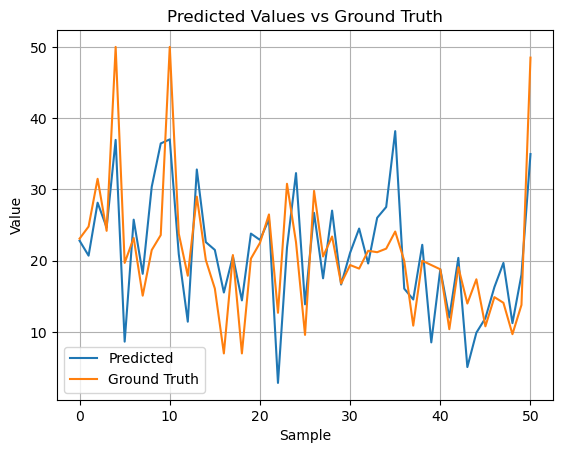

--------------------------------------------------------------------------------
Mean Squared Error (MSE)                 : 41.86
Root Mean Squared Error (RMSE)           : 6.47
R-squared (Coefficient of Determination) : 0.50
--------------------------------------------------------------------------------


In [888]:
mlp.predict()

---
### Resources (for theory only)

- https://medium.com/practical-coding/two-ways-to-do-regression-with-neural-networks-db29a4ef701#:~:text=It%20is%20common%20to%20scale,get%20a%20continuous%20valued%20output.

# WandB logging

In [25]:
i = 0
lr_list = [0.015,0.02,0.05,0.07,0.1]
af_list = ['ReLU']

for lr in lr_list:
    for af in af_list:
        for bs in range(100,201,50):
            print(i)
            i = i + 1
            wandb.init(
                # set the wandb project where this run will be logged
                project="MLPRegression",

                # track hyperparameters and run metadata
                config={
                'layer_sizes' : [11,5,5,6],
                'batch_size' : bs,
                'num_epoches' : 100,
                'learning_rate' : lr,
                'activation_function' : af,
                'optimization' : 'mini-batch'
                }
            )



            # parameters for the model
            # the 1st and last element of layer_sizes correspond to number of features and number of outputs
            layer_sizes = [13,5,5,1]
            batch_size = bs
            num_epoches = 500
            learning_rate = lr
            activation_function = af
            optimization = 'mini-batch'

            # creating the model object
            mlp = MLP(layer_sizes=layer_sizes,
                      batch_size=batch_size,
                      num_epoches=num_epoches,
                      learning_rate=learning_rate,
                      activation_function=activation_function,
                      optimization=optimization,
                     )

            mlp.loadData(df)
            mlp.splitData(0.8,True)
#             mlp.printParameters()
            mlp.fit()
            wandb.finish()


0


loss (MSE),▁
loss (MSE),2.5369750205065034e+23


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!


/tmp/ipykernel_35761/2829981479.py:150: RuntimeWarning: overflow encountered in square
  return np.sum((y_hat-y)**2)
/home/tejas/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


loss (MSE),nan


1


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!


loss (MSE),nan


2


Problem at: /tmp/ipykernel_35761/3686138369.py 10 <module>


KeyboardInterrupt: 